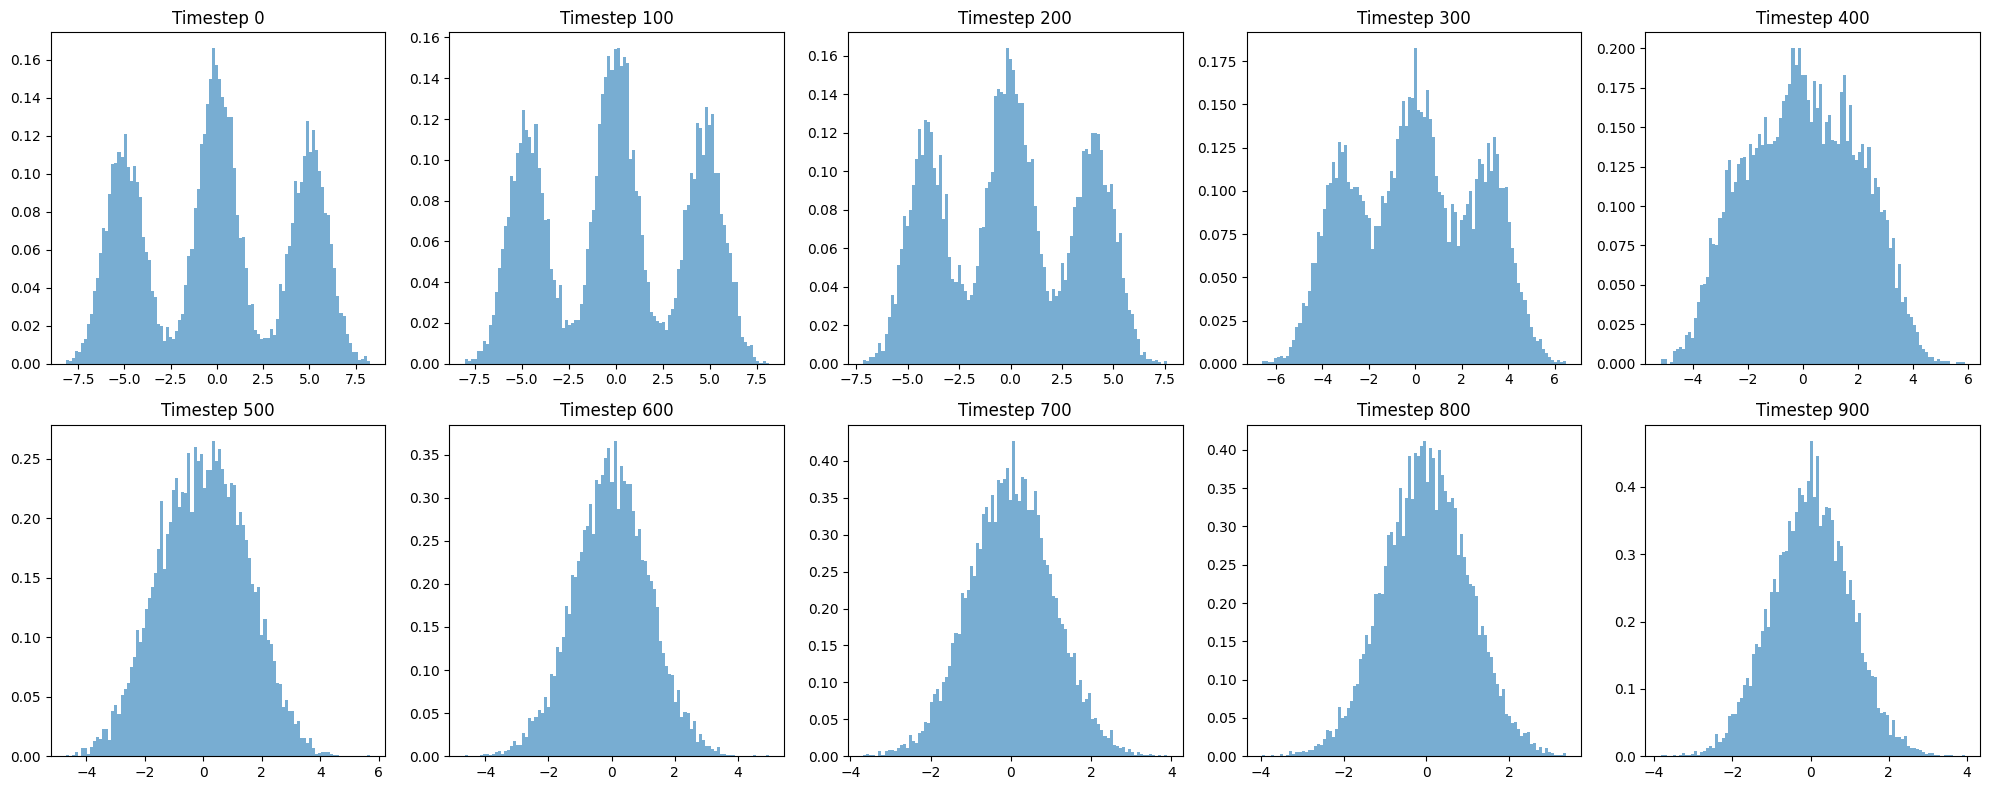

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the mixture of Gaussians
def mixture_of_gaussians(num_samples):
    means = [-5, 0, 5]
    stds = [1, 1, 1]
    proportions = [0.3, 0.4, 0.3]
    samples = []
    for mean, std, prop in zip(means, stds, proportions):
        samples.append(np.random.normal(mean, std, int(num_samples * prop)))
    return np.concatenate(samples)

# Parameters
num_samples = 10000
timesteps = 1000
beta = np.linspace(0.0001, 0.02, timesteps)  # Linear noise schedule

# Generate initial data
data = mixture_of_gaussians(num_samples)

# Forward diffusion process
def forward_diffusion(data, beta, timesteps):
    noisy_data = []
    for t in range(timesteps):
        noise = np.random.normal(0, 1, size=data.shape)
        data = np.sqrt(1 - beta[t]) * data + np.sqrt(beta[t]) * noise
        if t % 100 == 0 or t == timesteps - 1:  # Store every 100th step and the last step
            noisy_data.append(data)
    return noisy_data

# Apply forward diffusion
noisy_data = forward_diffusion(data, beta, timesteps)

# Visualization of the forward diffusion process
def visualize_forward_diffusion(noisy_data):
    plt.figure(figsize=(20, 8))
    timesteps_to_plot = list(range(0, timesteps, 100)) + [timesteps - 1]
    timesteps_to_plot = timesteps_to_plot[:10]  # Ensure we have at most 10 plots
    for i, data in enumerate(noisy_data[:10]):
        plt.subplot(2, 5, i + 1)  # Adjust the grid to 2 rows and 5 columns
        plt.hist(data, bins=100, density=True, alpha=0.6)
        plt.title(f'Timestep {timesteps_to_plot[i]}')
    plt.tight_layout()
    plt.show()

# Visualize forward diffusion
visualize_forward_diffusion(noisy_data)



In [7]:

# Define the neural network for reverse diffusion
class DenoiseNN(nn.Module):
    def __init__(self):
        super(DenoiseNN, self).__init__()
        # First fully connected layer: input size is 2 (noisy data + timestep), output size is 128
        self.fc1 = nn.Linear(2, 128)
        # Second fully connected layer: input size is 128, output size is 128
        self.fc2 = nn.Linear(128, 128)
        # Third fully connected layer: input size is 128, output size is 1 (predicted noise)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x, t):
        # Concatenate the noisy data (x) and the normalized timestep (t) along the feature dimension
        x = torch.cat((x, t), dim=1)
        # Pass the concatenated input through the first layer followed by a ReLU activation function
        x = torch.relu(self.fc1(x))
        # Pass the output through the second layer followed by a ReLU activation function
        x = torch.relu(self.fc2(x))
        # Pass the output through the third layer to get the final predicted noise
        x = self.fc3(x)
        return x

# Preparing the dataset for training
def create_dataset(data, beta, timesteps):
    dataset_x = []  # List to store noisy data at each timestep
    dataset_t = []  # List to store timesteps
    dataset_y = []  # List to store the true noise added at each timestep

    for t in range(timesteps):
        # Generate noise for the current timestep
        noise = np.random.normal(0, 1, size=data.shape)
        # Add noise to the data according to the forward diffusion process
        noisy_data = np.sqrt(1 - beta[t]) * data + np.sqrt(beta[t]) * noise
        # Append the noisy data to the dataset_x list
        dataset_x.append(noisy_data)
        # Append the current timestep to the dataset_t list
        dataset_t.append(np.full_like(data, t))
        # Append the generated noise to the dataset_y list
        dataset_y.append(noise)

    # Concatenate lists to form arrays for the entire dataset
    dataset_x = np.concatenate(dataset_x)
    dataset_t = np.concatenate(dataset_t)
    dataset_y = np.concatenate(dataset_y)

    return dataset_x, dataset_t, dataset_y


In [8]:

# Create dataset for training
dataset_x, dataset_t, dataset_y = create_dataset(data, beta, timesteps)
dataset_x = torch.tensor(dataset_x, dtype=torch.float32).view(-1, 1)
dataset_t = torch.tensor(dataset_t, dtype=torch.float32).view(-1, 1) / timesteps
dataset_y = torch.tensor(dataset_y, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(dataset_x, dataset_t, dataset_y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize the model, loss function, and optimizer
model = DenoiseNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
print("x data",dataset_x[:10])
print("t data",dataset_t)
print("y data",dataset_y[:10])


x data tensor([[-3.7507],
        [-4.2470],
        [-5.4270],
        [-5.8648],
        [-4.8590],
        [-4.1878],
        [-6.2775],
        [-5.3193],
        [-5.8124],
        [-5.4865]])
t data tensor([[0.0000],
        [0.0000],
        [0.0000],
        ...,
        [0.9990],
        [0.9990],
        [0.9990]])
y data tensor([[ 1.8801],
        [ 0.3958],
        [ 1.2670],
        [-0.0152],
        [-1.1552],
        [-0.8710],
        [ 1.5027],
        [ 0.3172],
        [-0.7826],
        [ 0.0964]])


In [14]:

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for x, t, y in train_loader:
        optimizer.zero_grad()
        output = model(x, t)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 1.0903
Epoch [2/20], Loss: 1.0892
Epoch [3/20], Loss: 1.0653
Epoch [4/20], Loss: 0.9751
Epoch [5/20], Loss: 1.0382
Epoch [6/20], Loss: 0.8822
Epoch [7/20], Loss: 1.0880
Epoch [8/20], Loss: 1.1013
Epoch [9/20], Loss: 1.2834
Epoch [10/20], Loss: 1.0890
Epoch [11/20], Loss: 1.0210
Epoch [12/20], Loss: 0.9181
Epoch [13/20], Loss: 1.2319
Epoch [14/20], Loss: 1.0369
Epoch [15/20], Loss: 0.7661
Epoch [16/20], Loss: 1.1163
Epoch [17/20], Loss: 1.0817
Epoch [18/20], Loss: 0.9658
Epoch [19/20], Loss: 0.7365
Epoch [20/20], Loss: 0.8711


In [15]:

# Reverse diffusion process
def reverse_diffusion(noise_data, model, beta, timesteps):
    data = noise_data[-1]
    reverse_data = [data]
    for t in reversed(range(timesteps)):
        data = torch.tensor(data, dtype=torch.float32).view(-1, 1)
        t_tensor = torch.tensor([t/timesteps], dtype=torch.float32).repeat(data.shape[0], 1)
        predicted_noise = model(data, t_tensor).detach().numpy().flatten()
        data = (data.numpy().flatten() - np.sqrt(beta[t]) * predicted_noise) / np.sqrt(1 - beta[t])
        if t % 100 == 0 or t == 0:
            reverse_data.append(data)
    return reverse_data

# Apply reverse diffusion
reverse_data = reverse_diffusion(noisy_data, model, beta, timesteps)

# Visualization of the reverse diffusion process
def visualize_reverse_diffusion(reverse_data):
    plt.figure(figsize=(20, 8))
    timesteps_to_plot = list(range(timesteps, 0, -100)) + [0]
    timesteps_to_plot = timesteps_to_plot[:10]  # Ensure we have at most 10 plots
    for i, data in enumerate(reverse_data[:10]):
        plt.subplot(2, 5, i + 1)  # Adjust the grid to 2 rows and 5 columns
        plt.hist(data, bins=100, density=True, alpha=0.6)
        plt.title(f'Timestep {timesteps_to_plot[i]}')
    plt.tight_layout()
    plt.show()

# Visualize reverse diffusion
visualize_reverse_diffusion(reverse_data)